In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs import *
from sparse_rf.modules import make_X, make_A
from sparse_rf.util import *
from sparse_rf.util.polynomials import *
from functools import partial
import random
import gc

In [110]:
def htp(A, y, s):
    def step(x):
        out = np.zeros(len(x))
        z = x + A.T@(y-A@x)
        inds = np.sort(np.argpartition(np.abs(z), -s)[-s:])
        nonzero = min_l2(A[:, inds], y)
        out[inds] = nonzero
        return out
    return step

def make_W(d, q, n=1, dist=normal):
    num_supports = comb(d, q)
    W = np.zeros((n*num_supports, d))
    inds = combinations(range(d), d-q)
    ds = set(range(d))
    inds_track = []
    for i in range(num_supports):
        ind = next(inds)
        inds_track.append(ds.difference(set(ind)))
        for j in range(n):
            w = dist(d)
            w[list(ind)] = 0
            W[i*n+j, :] = w
    return W, inds_track
        

In [113]:
m = 1000
d = 5
q = 5
N = 10000
n = N // comb(d, q)
active = fourier

ratio_train = 0.7

In [114]:
X = make_X(d, m, dist=uniform)
X_train = X[:int(m*ratio_train), :]
X_test = X[int(m*ratio_train):, :]

y = np.array(list(map(fn1, X)))
y_train = y[:int(m*ratio_train)]
y_test = y[int(m*ratio_train):]

In [115]:
W, inds = make_W(d, q, n=n, dist=normal)
A_train = make_A(X_train, W, active=active)
A_test = make_A(X_test, W, active=active)

In [116]:
inds

[{0, 1, 2, 3, 4}]

In [118]:
htp_step = htp(A_train, y_train, N)
c_htp = np.zeros(A_train.shape[-1])
for _ in range(2):
    c_htp = htp_step(c_htp)
np.linalg.norm(A_test@c_htp - y_test) / np.linalg.norm(y_test)

0.0037287295671751134

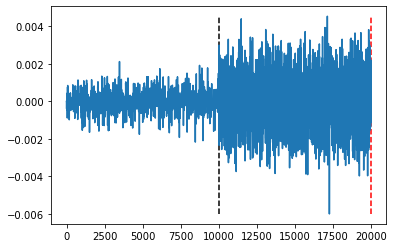

In [119]:
plt.plot(c_htp)
for i in range(len(inds)):
    plt.vlines((len(c_htp)//(2*len(inds)))*(i+1), min(c_htp), max(c_htp), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_htp)//(2*len(inds)))*(i+len(inds)+1), min(c_htp), max(c_htp), color="red", linestyles="--")

In [120]:
c_l2 = min_l2(A_train, y_train)
np.linalg.norm(A_test@c_l2 - y_test) / np.linalg.norm(y_test)

0.00848995956015699

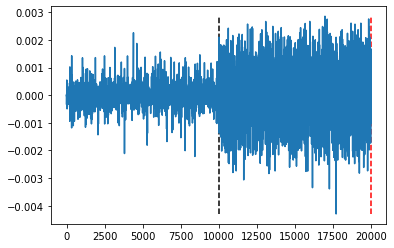

In [121]:
plt.plot(c_l2)
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+1), min(c_l2), max(c_l2), color="black", linestyles="--")
for i in range(len(inds)):
    plt.vlines((len(c_l2)//(2*len(inds)))*(i+len(inds)+1), min(c_l2), max(c_l2), color="red", linestyles="--")